In [1]:
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

env: WANDB_SILENT=true


In [2]:
import torch
from utils.audio import *
from IPython.display import Audio, display

In [3]:
SAMPLE_RATE = 16000

clean = load_librispeech(1)
noisy = get_noisy_audio(clean, std=0.1)

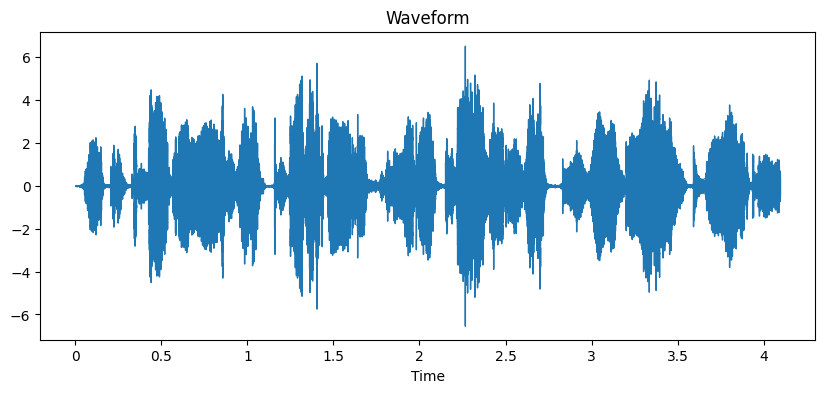

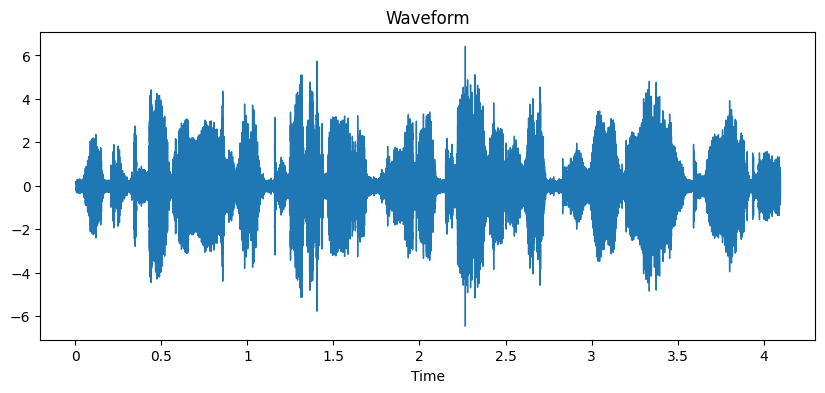

In [4]:
plot_waveform(clean[0].flatten())
plot_waveform(noisy[0].flatten())

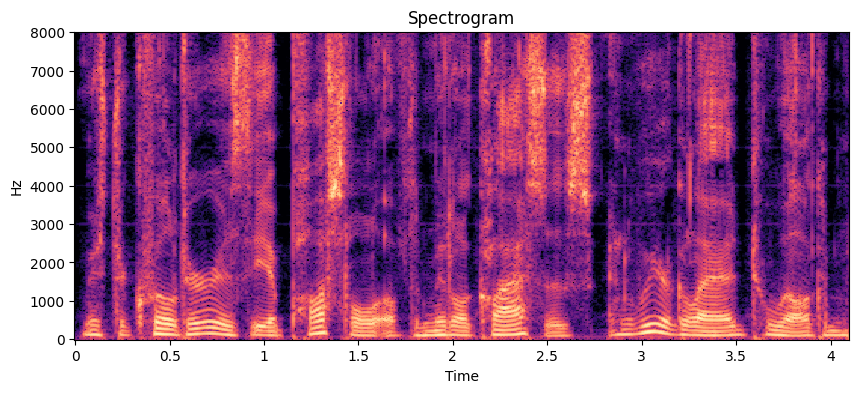

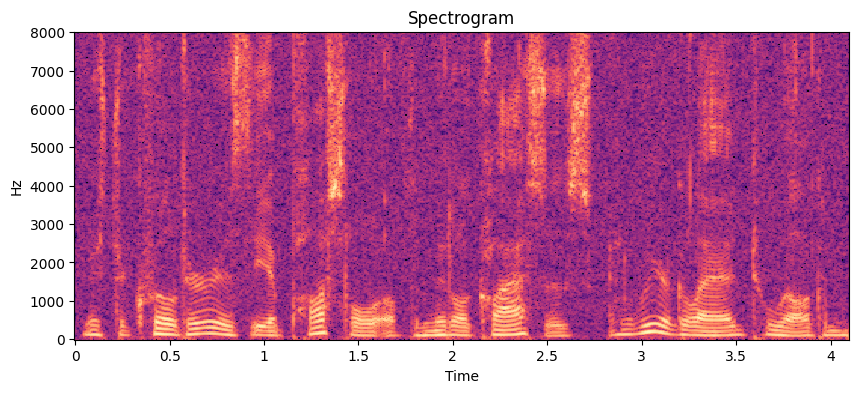

In [5]:
plot_spectrogram(clean[0].flatten())
plot_spectrogram(noisy[0].flatten())

In [6]:
display(Audio(clean[0].flatten(), rate=SAMPLE_RATE))
display(Audio(noisy[0].flatten(), rate=SAMPLE_RATE))

In [7]:
class FromFourier(torch.nn.Module):
    def __init__(self, metric):
        super().__init__()

        self.metric = metric

    def forward(self, x, y):
        x = from_fourier(x)
        y = from_fourier(y)
        return self.metric(x, y)

Running: 0.0 - DIP - MSE + TV (alpha=2) - UNetMod 


100%|██████████| 2000/2000 [04:28<00:00,  7.46it/s]


Summary: {'runtime': '00:04:28', 'psnr': -0.8735602498054504, 'snr': 16.913480758666992, 'pesq': 2.4687767028808594}



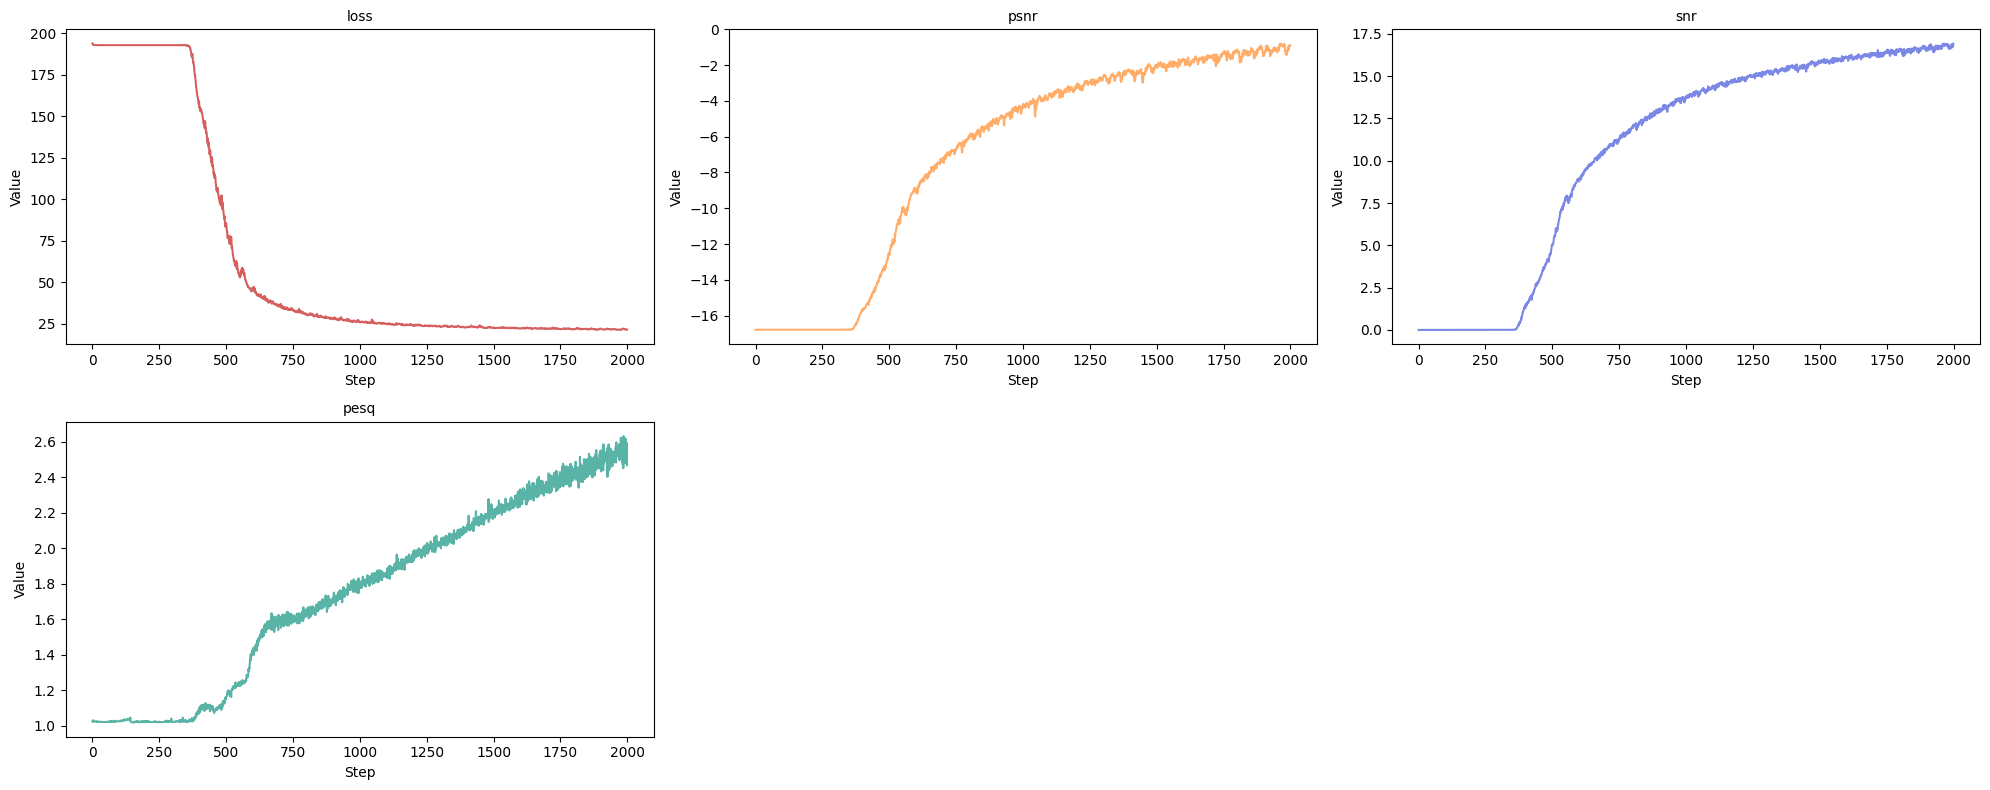

Running: 0.1 - DIP - MSE + TV (alpha=2) - UNetMod 


100%|██████████| 2000/2000 [05:10<00:00,  6.44it/s]


Summary: {'runtime': '00:05:10', 'psnr': -2.122504234313965, 'snr': 15.845685958862305, 'pesq': 1.7323498725891113}



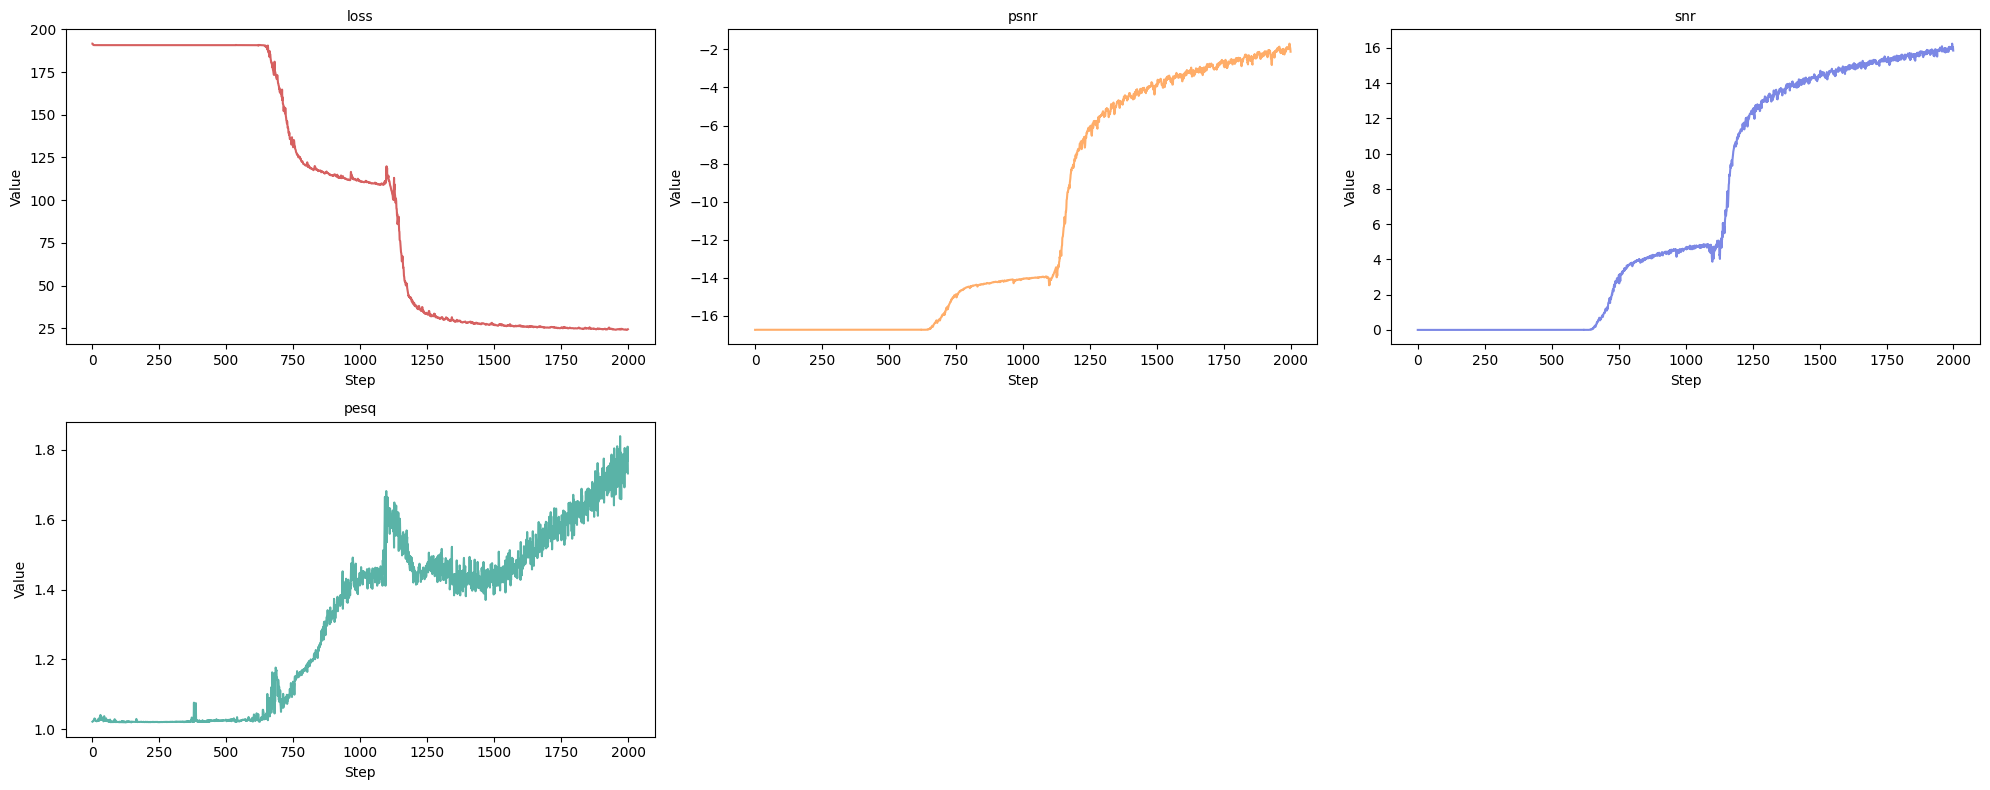

Running: 0.2 - DIP - MSE + TV (alpha=2) - UNetMod 


100%|██████████| 2000/2000 [04:55<00:00,  6.76it/s]


Summary: {'runtime': '00:04:55', 'psnr': -3.1558451652526855, 'snr': 14.871049880981445, 'pesq': 1.7199347019195557}



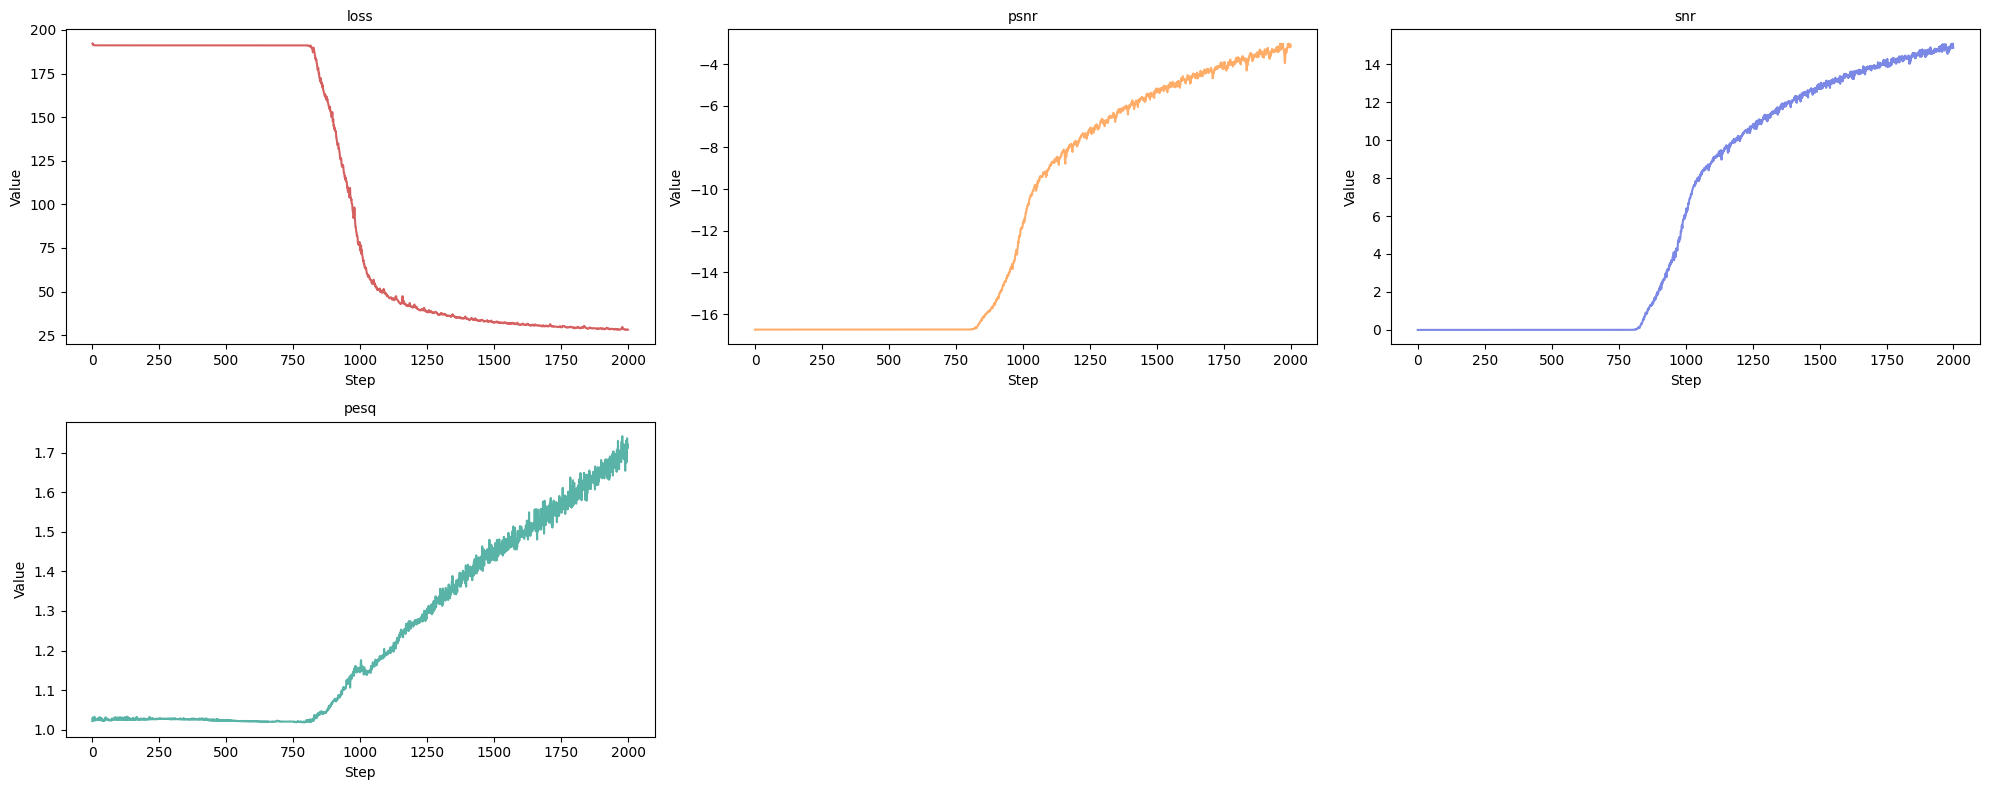

Running: 0.3 - DIP - MSE + TV (alpha=2) - UNetMod 


100%|██████████| 2000/2000 [04:54<00:00,  6.79it/s]


Summary: {'runtime': '00:04:54', 'psnr': -0.0944775640964508, 'snr': 17.723081588745117, 'pesq': 2.430213451385498}



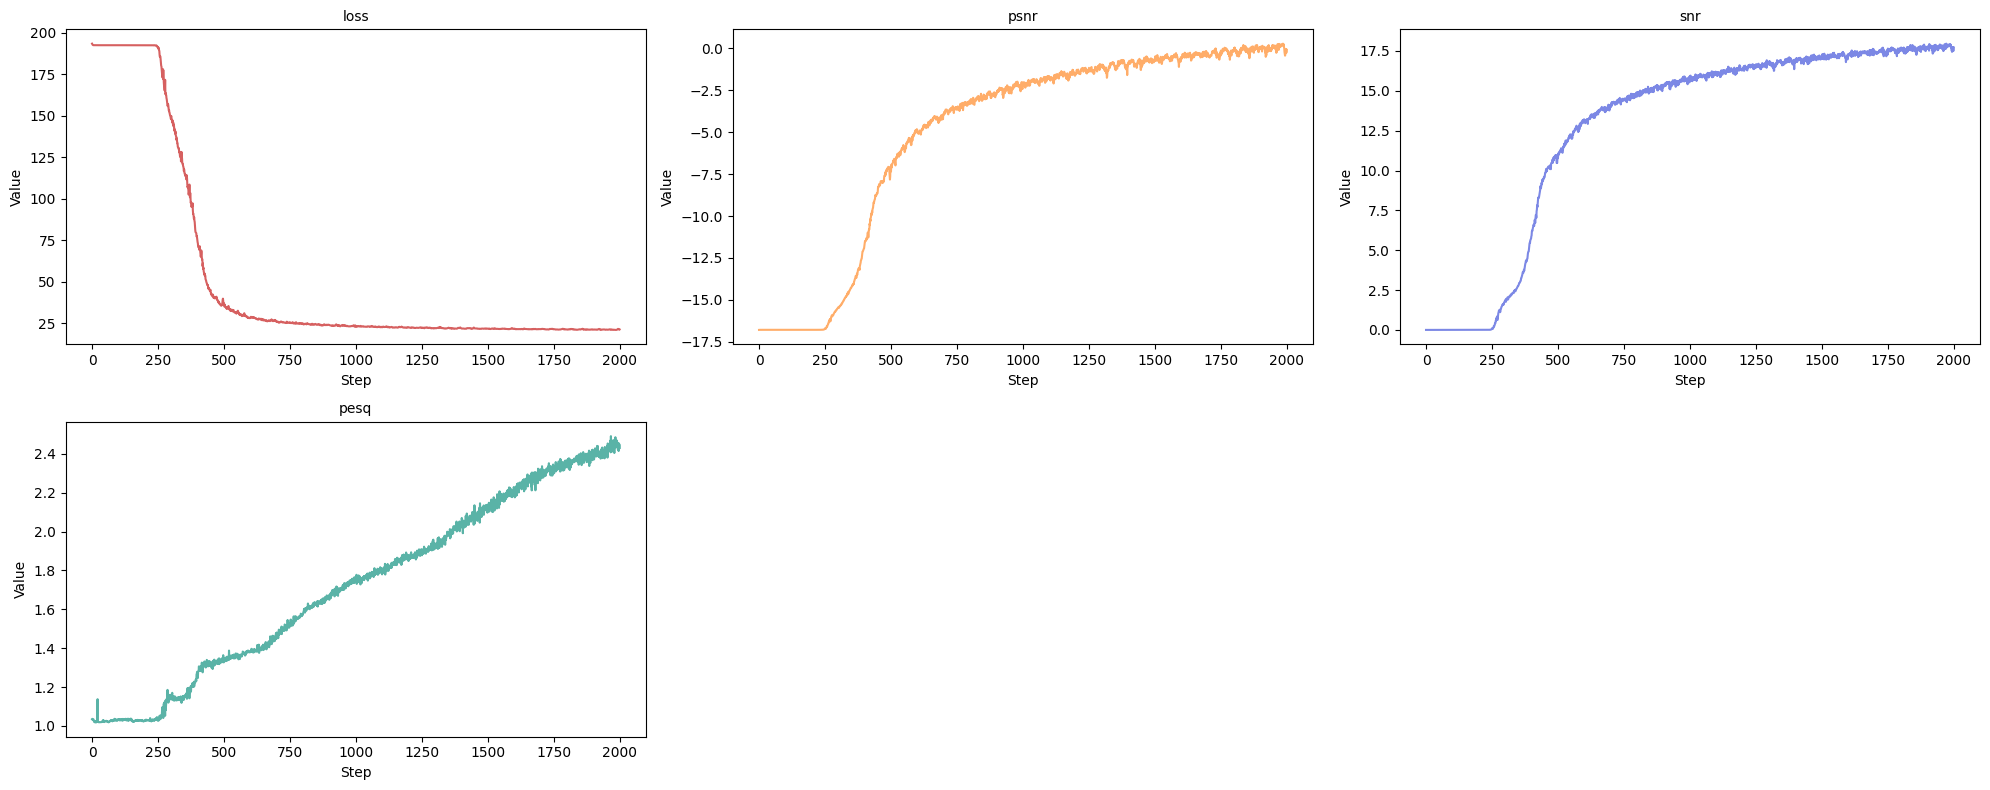

In [ ]:
from models import UNetMod
from denoisers.dip import DIP, losses
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics.audio import SignalNoiseRatio, PerceptualEvaluationSpeechQuality

psnr_f = PeakSignalNoiseRatio(data_range=2)
snr_f = FromFourier(SignalNoiseRatio())
pesq_f = FromFourier(PerceptualEvaluationSpeechQuality(fs=16000, mode='wb'))

net = UNetMod(in_ch=2, out_ch=2, n_layers=2, hidden_ch=64)

tv = losses.Composed(losses.MSE(), losses.TV(), alpha=2)
dip = DIP(net, tv, lr=0.01)

denoised = []
for i, (y, x) in enumerate(zip(noisy, clean)):
    x_hat = []
    for j in range(len(y)): 
        y_f = to_fourier(y[j])
        x_f = to_fourier(x[j])

        options={
            "mode": "local",
            "metrics": {"psnr": psnr_f, "snr": snr_f, "pesq": pesq_f},
            "log_output": True,
            "config": {"data_id": f"{i}.{j}"}
        }

        x_hat_f = dip.denoise(y_f.unsqueeze(0), x_f.unsqueeze(0), options)
        x_hat_f = x_hat_f.detach().cpu().squeeze(0)
        x_hat.append(from_fourier(x_hat_f))
    denoised.append(torch.stack(x_hat))

In [19]:
snr = SignalNoiseRatio()
pesq = PerceptualEvaluationSpeechQuality(fs=16000, mode='wb')

print("SNR:")
print(snr(noisy[0].flatten(), clean[0].flatten()).item())
print(snr(denoised[0].flatten(), clean[0].flatten()).item())
print("\nPESQ:")
print(pesq(noisy[0].flatten(), clean[0].flatten()).item())
print(pesq(denoised[0].flatten(), clean[0].flatten()).item())

SNR:
19.999435424804688
16.204689025878906

PESQ:
1.466606855392456
1.8294320106506348


In [18]:
denoised[0].shape

torch.Size([4, 16384])

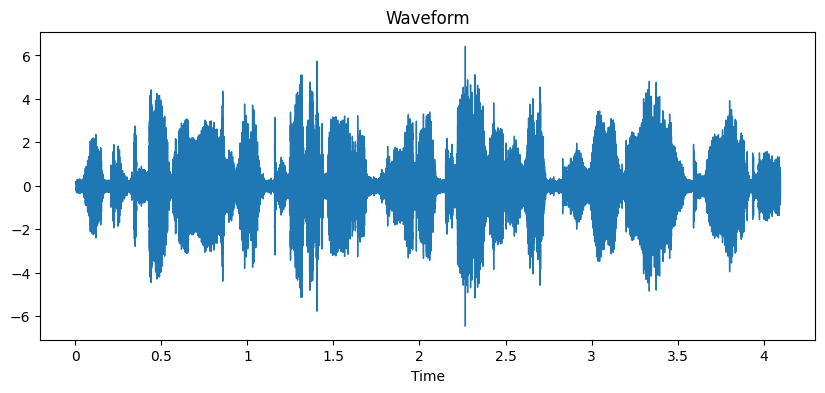

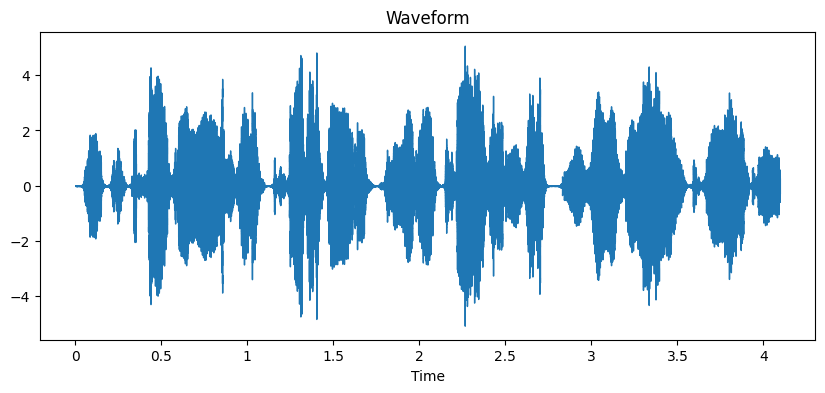

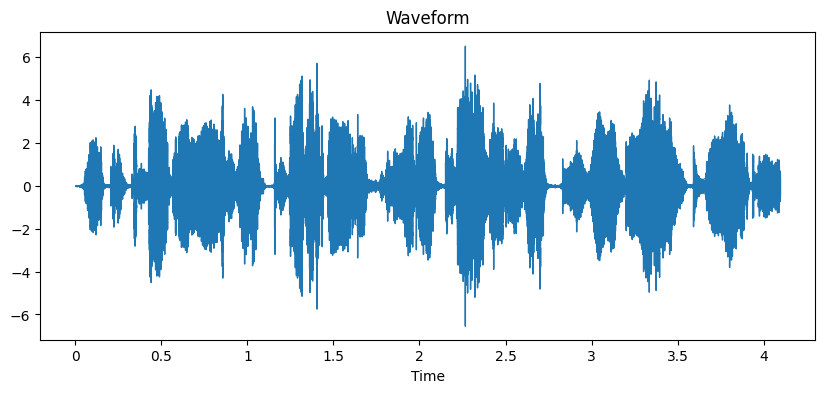

In [10]:
plot_waveform(noisy[0].flatten())
plot_waveform(denoised[0].flatten())
plot_waveform(clean[0].flatten())

In [11]:
display(Audio(noisy[0].flatten().numpy(), rate=SAMPLE_RATE))
display(Audio(denoised[0].flatten().numpy(), rate=SAMPLE_RATE))
display(Audio(clean[0].flatten().numpy(), rate=SAMPLE_RATE))

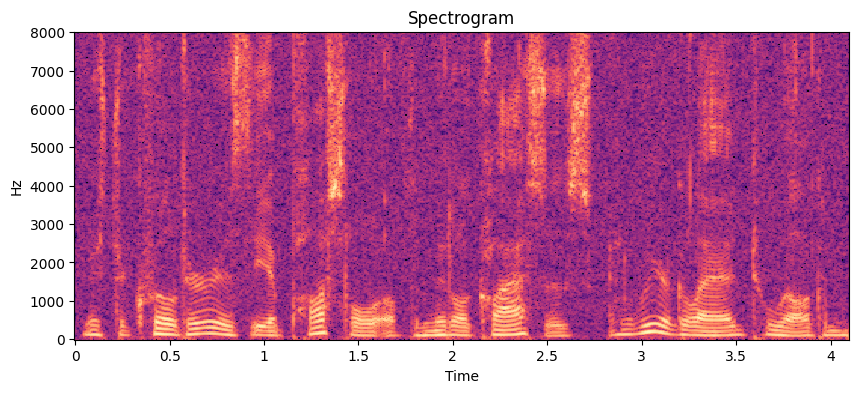

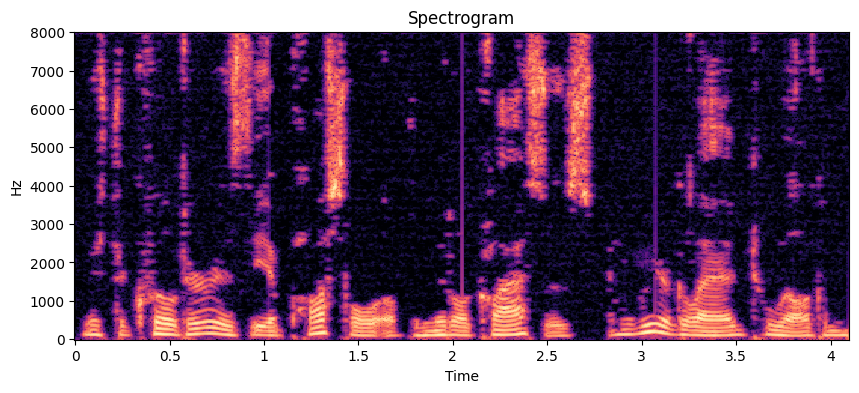

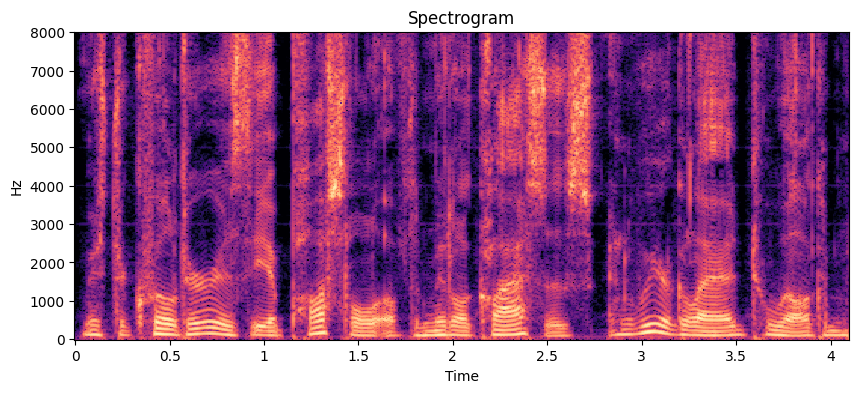

In [12]:
plot_spectrogram(noisy[0].flatten())
plot_spectrogram(denoised[0].flatten())
plot_spectrogram(clean[0].flatten())